# 杭州市萧山区项目`WRF-CMAQ`模拟分析
## `LEX`与`MEIC`模拟结果对比

---
*@author: Evan*\
*@date: 2023-08-08*

In [11]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
        "font.family":'Times New Roman',
        "mathtext.fontset":'stix',
        "font.serif": ['Times New Roman'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *
# import ModelEvaLib as me

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [3]:
def polygon_to_mask(polygon, x, y):
    """
    Generate a mask array indicating points falling within the polygon.

    Args:
        polygon (shapely.geometry.Polygon): Polygon object defining the boundary.
        x (array-like): Array of x coordinates.
        y (array-like): Array of y coordinates.

    Returns:
        mask (numpy array): Boolean mask array indicating points within the polygon.
    """

    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

def mask_to_mean(var,mask_da):
    '''
    Calculate the mean of a variable after applying a mask.

    Parameters:
        var (xarray.DataArray): Input variable.
        mask_da (xarray.DataArray): Mask with dimensions ('y', 'x').

    Returns:
        xarray.DataArray: Mean of the masked variable along dimensions ('y', 'x').

    '''
    
    masked = var.where(mask_da)
    mean = masked.mean(dim=['y','x'],skipna=True)
    
    return mean

In [4]:
meic = xr.open_dataset(meic_ncfile)
lex = xr.open_dataset(lex_ncfile)

In [5]:
lon = meic.longitude
lat = meic.latitude
shp = gpd.read_file(shpxs)

mask = polygon_to_mask(shp.geometry[0],lon,lat)
mask_da = xr.DataArray(mask,dims=('y','x'))

In [6]:
vars_list = ['CO', 'O3', 'NO', 'NO2', 'SO2', 'VOC', 'PM25', 'PM10']

meic_vars = []
lex_vars = []
for i in range(len(vars_list)): 
    meic_vars.append(meic[vars_list[i]])
    lex_vars.append(lex[vars_list[i]])

In [7]:
L1_meic_dict = {}
L1_lex_dict = {}

for var, data in zip(vars_list, meic_vars):
    L1_meic_dict[f"{var}"] = data[:,0,:,:]
    
for var, data in zip(vars_list, lex_vars):
    L1_lex_dict[f"{var}"] = data[:,0,:,:]
    

In [8]:
meic_mean = {}
lex_mean = {}
for key, variable in L1_meic_dict.items():
    meic_mean[key] = mask_to_mean(variable, mask_da)
    
for key, variable in L1_lex_dict.items():
    lex_mean[key] = mask_to_mean(variable, mask_da)

In [9]:
df_meic = pd.DataFrame.from_dict(meic_mean, orient='columns')
df_meic.index = pd.date_range(timestart,timeend,freq='h')

df_lex = pd.DataFrame.from_dict(lex_mean, orient='columns')
df_lex.index = pd.date_range(timestart,timeend,freq='h')

## 观测数据

In [15]:
hzobs = pd.read_excel('D:/data/Project_Xiaoshan/TEST_SIM/obsdata/hz_avg_2306.xlsx',index_col=0)
xsobs = pd.read_excel('D:/data/Project_Xiaoshan/TEST_SIM/obsdata/sites_2306/杭州-城厢镇.xlsx',index_col=0)
xsobs.interpolate(method='time', inplace=True)

## 画图

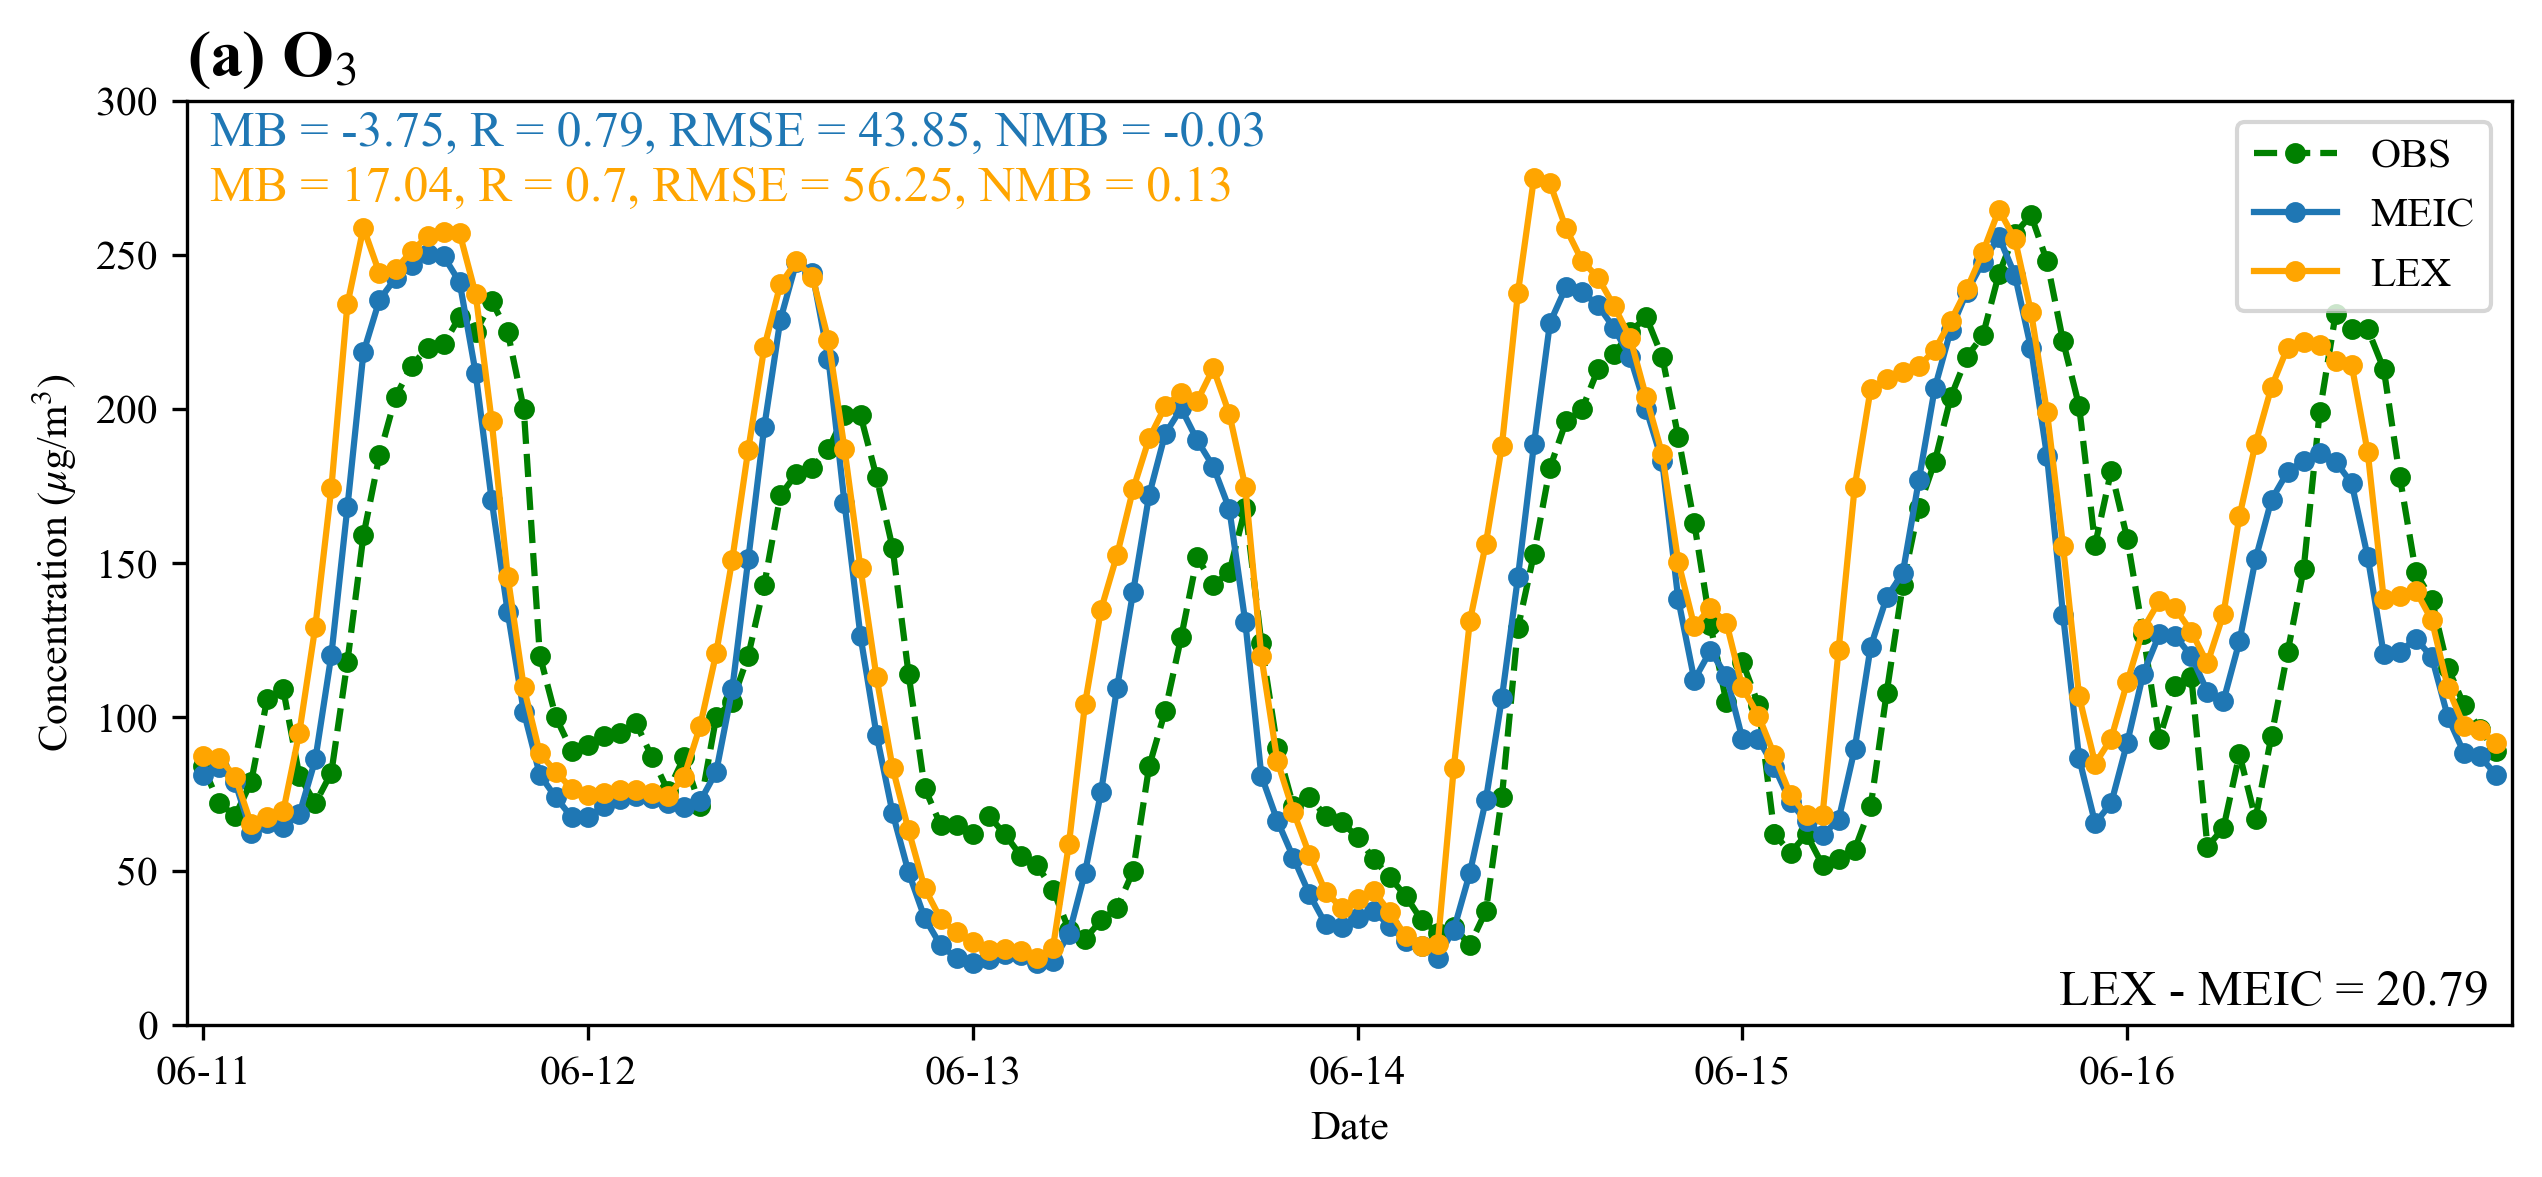

In [21]:
var = 'O3'
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,xsobs[var],**obs_args)
ax.plot(ts,df_meic[var],**meic_args)
ax.plot(ts,df_lex[var],**lex_args)
ax.legend(loc=1)

# calculate parameters
MB_meic = np.nanmean(df_meic[var]-xsobs[var])
R_meic,_ = pearsonr(xsobs[var],df_meic[var])
RMSE_meic = np.sqrt(np.nanmean((df_meic[var]-xsobs[var])**2))
NMB_meic = MB_meic / np.mean(xsobs[var])

MB_lex = np.nanmean(df_lex[var]-xsobs[var])
R_lex,_ = pearsonr(xsobs[var],df_lex[var])
RMSE_lex = np.sqrt(np.nanmean((df_lex[var]-xsobs[var])**2))
NMB_lex = MB_lex / np.mean(xsobs[var])

diff_mean = np.nanmean(df_lex[var]-df_meic[var])

# strings
str_mb_meic   = 'MB = '+str(np.round(MB_meic,2))+', '
str_r_meic    = 'R = '+str(np.round(R_meic,2))+', '
str_rmse_meic = 'RMSE = '+str(np.round(RMSE_meic,2))+', '
str_nmb_meic  = 'NMB = '+str(np.round(NMB_meic,2))
str_meic      = str_mb_meic+str_r_meic+str_rmse_meic+str_nmb_meic

ax.text(x=0.01,y=0.99,s=str_meic,color='tab:blue',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mb_lex   = 'MB = '+str(np.round(MB_lex,2))+', '
str_r_lex    = 'R = '+str(np.round(R_lex,2))+', '
str_rmse_lex = 'RMSE = '+str(np.round(RMSE_lex,2))+', '
str_nmb_lex  = 'NMB = '+str(np.round(NMB_lex,2))
str_lex      = str_mb_lex+str_r_lex+str_rmse_lex+str_nmb_lex

ax.text(x=0.01,y=0.93,s=str_lex,color='orange',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mean = 'LEX - MEIC = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)

ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,301,50))
ax.set_ylim(0,300)
ax.set_xlim(-1,hours)
ax.set_title('(a) O$_3$',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

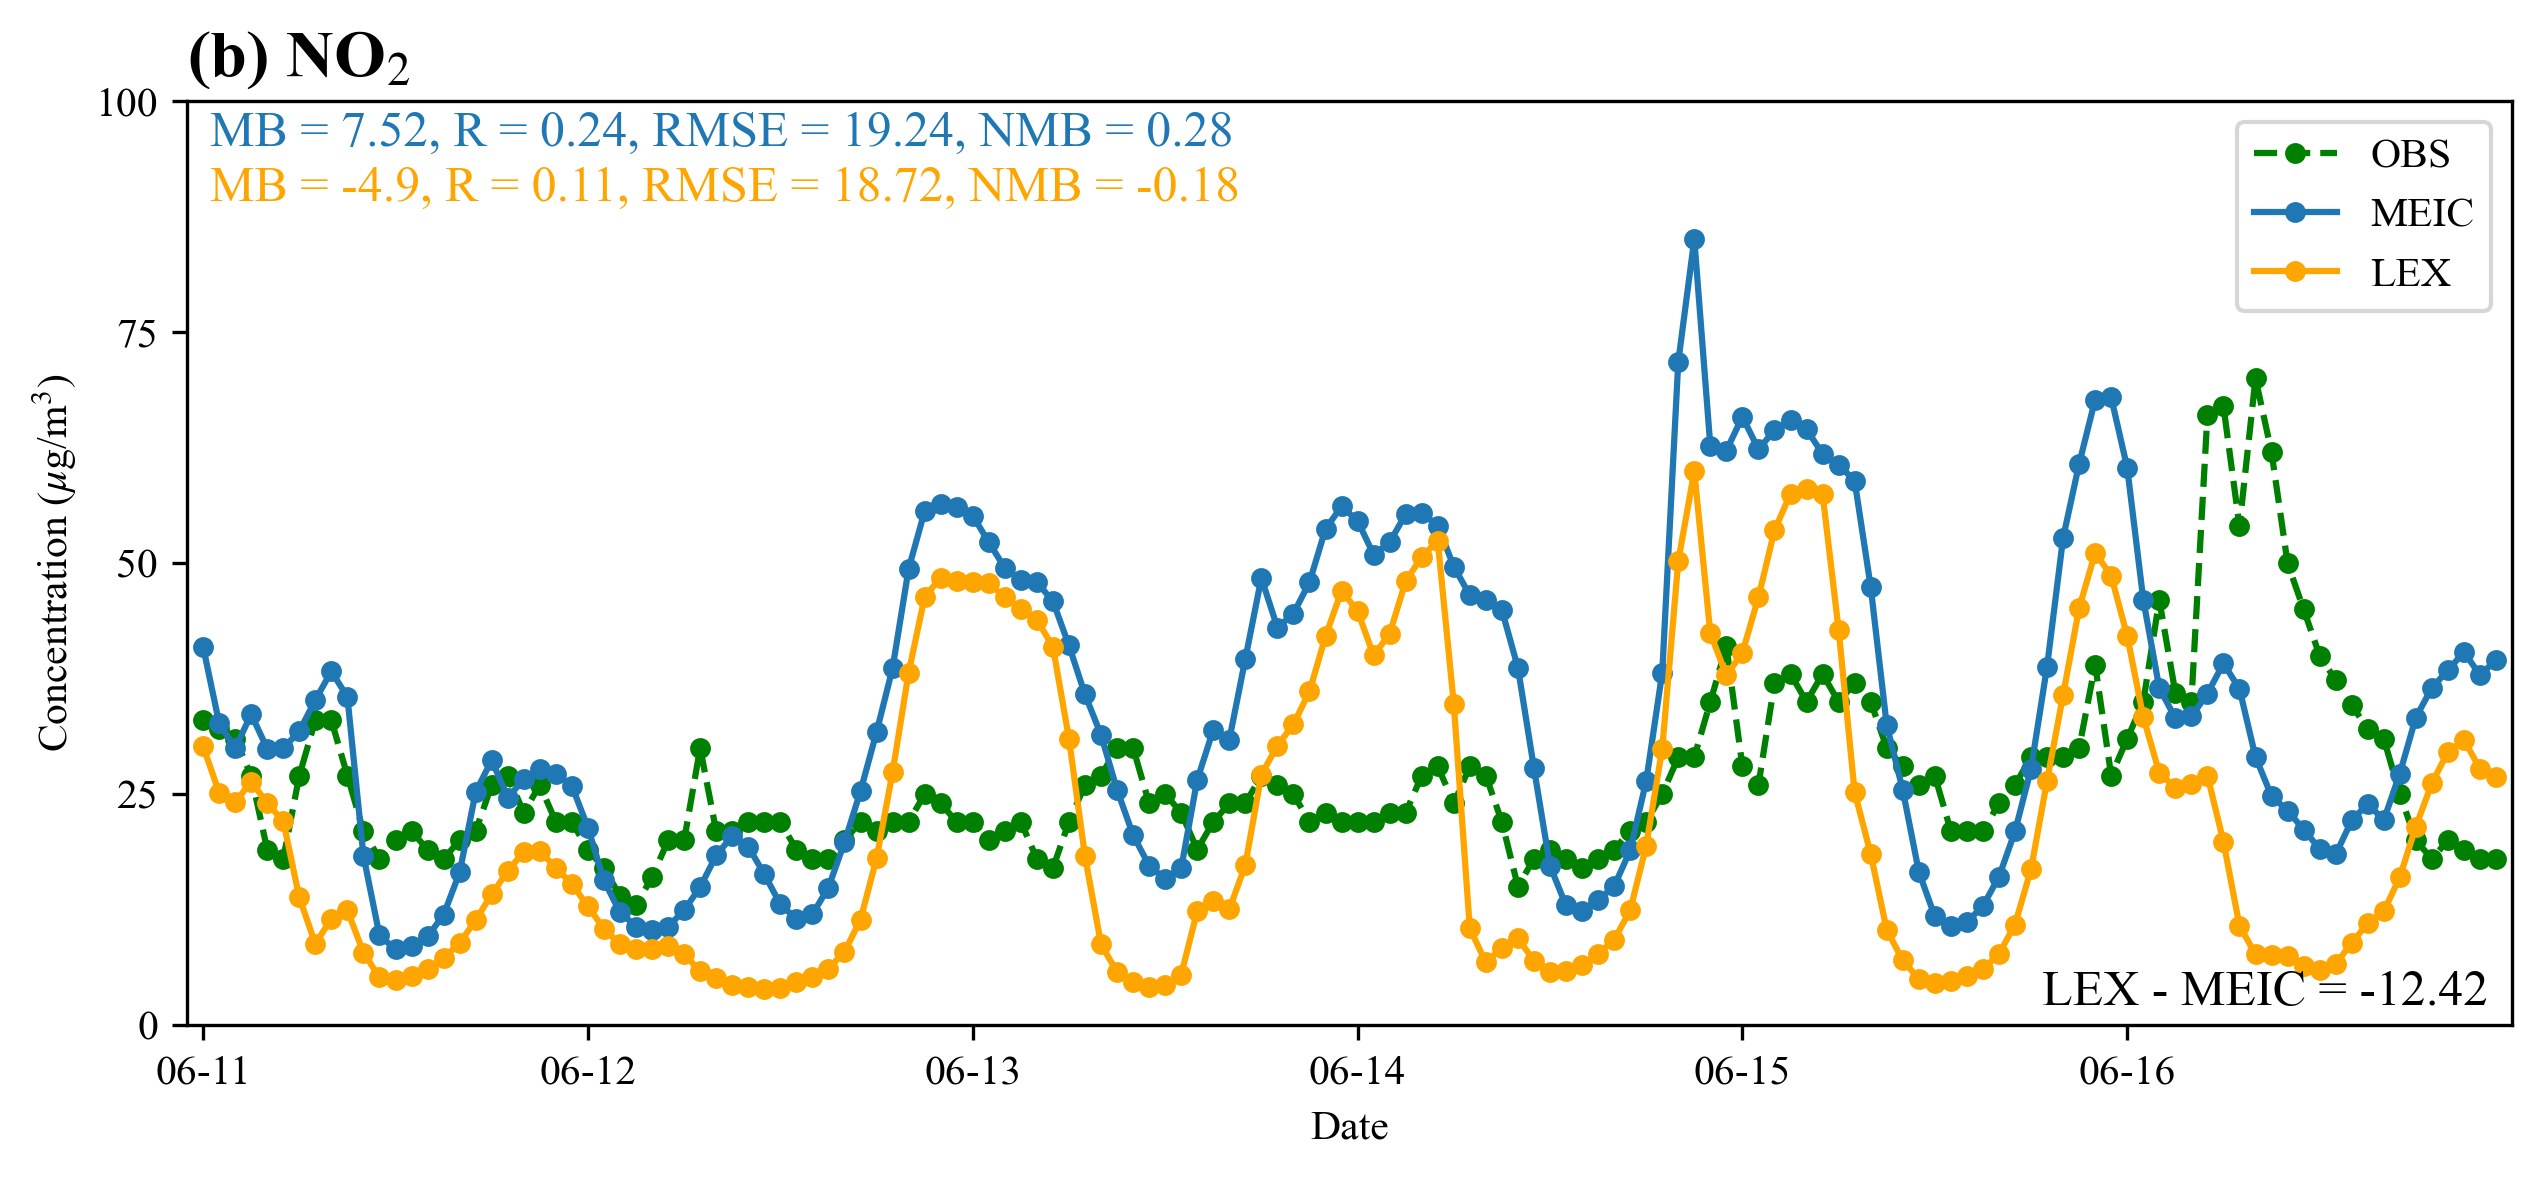

In [23]:
var='NO2'
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,xsobs[var],**obs_args)
ax.plot(ts,df_meic[var],**meic_args)
ax.plot(ts,df_lex[var],**lex_args)
ax.legend(loc=1)

# calculate parameters
MB_meic = np.nanmean(df_meic[var]-xsobs[var])
R_meic,_ = pearsonr(xsobs[var],df_meic[var])
RMSE_meic = np.sqrt(np.nanmean((df_meic[var]-xsobs[var])**2))
NMB_meic = MB_meic / np.mean(xsobs[var])

MB_lex = np.nanmean(df_lex[var]-xsobs[var])
R_lex,_ = pearsonr(xsobs[var],df_lex[var])
RMSE_lex = np.sqrt(np.nanmean((df_lex[var]-xsobs[var])**2))
NMB_lex = MB_lex / np.mean(xsobs[var])

diff_mean = np.nanmean(df_lex[var]-df_meic[var])

# strings
str_mb_meic   = 'MB = '+str(np.round(MB_meic,2))+', '
str_r_meic    = 'R = '+str(np.round(R_meic,2))+', '
str_rmse_meic = 'RMSE = '+str(np.round(RMSE_meic,2))+', '
str_nmb_meic  = 'NMB = '+str(np.round(NMB_meic,2))
str_meic      = str_mb_meic+str_r_meic+str_rmse_meic+str_nmb_meic

ax.text(x=0.01,y=0.99,s=str_meic,color='tab:blue',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mb_lex   = 'MB = '+str(np.round(MB_lex,2))+', '
str_r_lex    = 'R = '+str(np.round(R_lex,2))+', '
str_rmse_lex = 'RMSE = '+str(np.round(RMSE_lex,2))+', '
str_nmb_lex  = 'NMB = '+str(np.round(NMB_lex,2))
str_lex      = str_mb_lex+str_r_lex+str_rmse_lex+str_nmb_lex

ax.text(x=0.01,y=0.93,s=str_lex,color='orange',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mean = 'LEX - MEIC = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)

ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,101,25))
ax.set_ylim(0,100)
ax.set_xlim(-1,hours)
ax.set_title('(b) NO$_2$',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

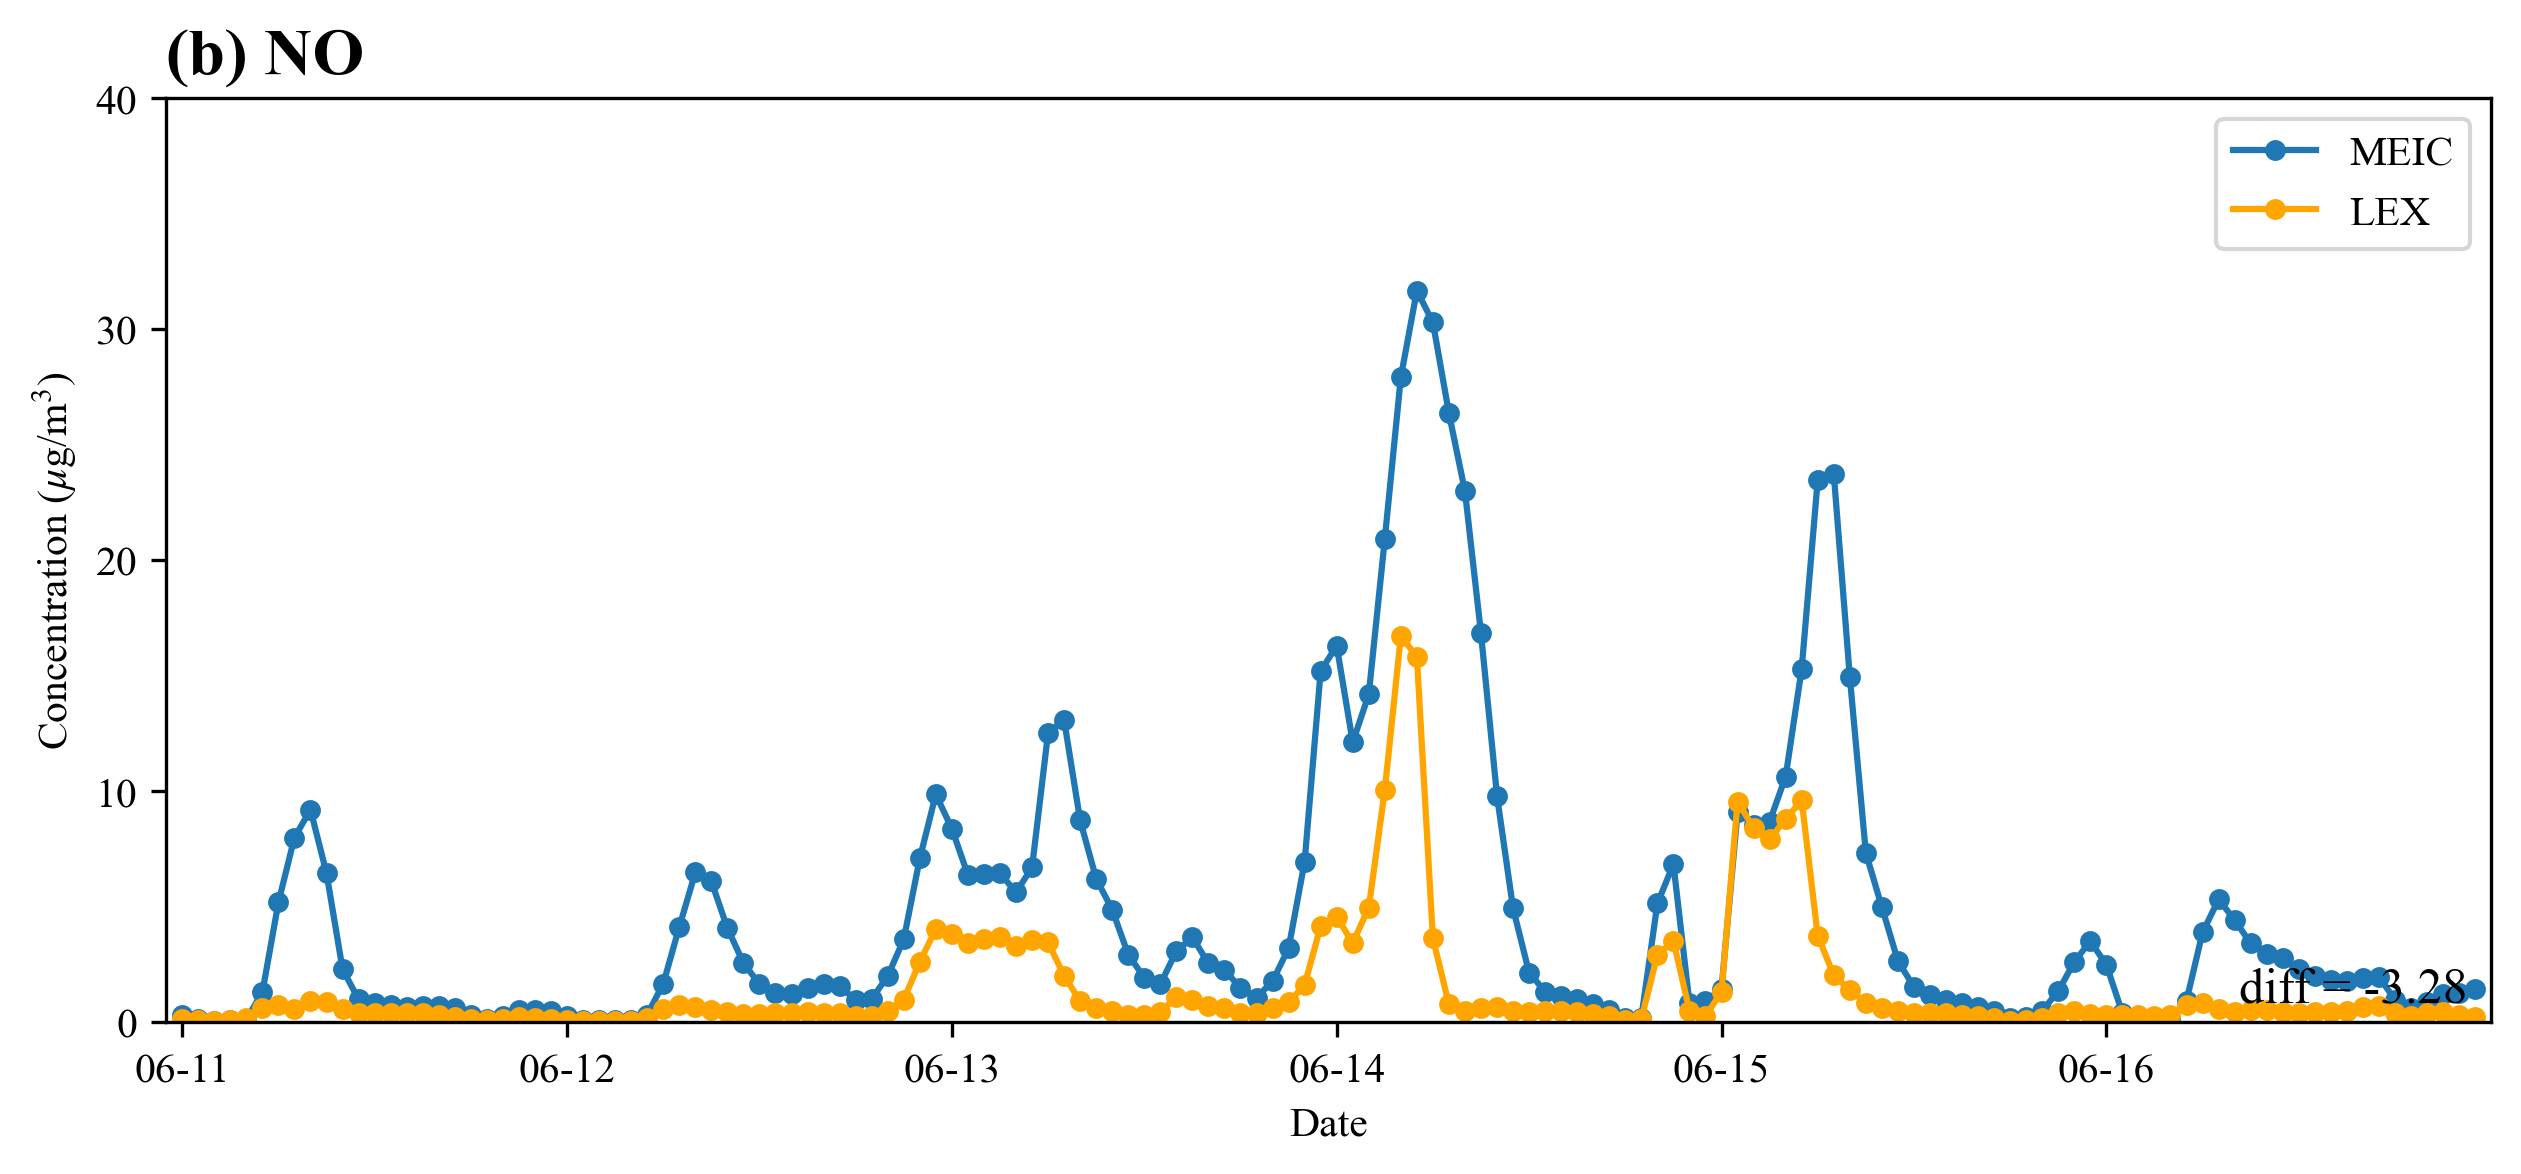

In [27]:
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,df_meic['NO'],**meic_args)
ax.plot(ts,df_lex['NO'],**lex_args)
ax.legend(loc=1)

diff_mean = np.mean(df_lex['NO']-df_meic['NO'])
str_mean = 'diff = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)

ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,41,10))
ax.set_ylim(0,40)
ax.set_xlim(-1,hours)
ax.set_title('(b) NO',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

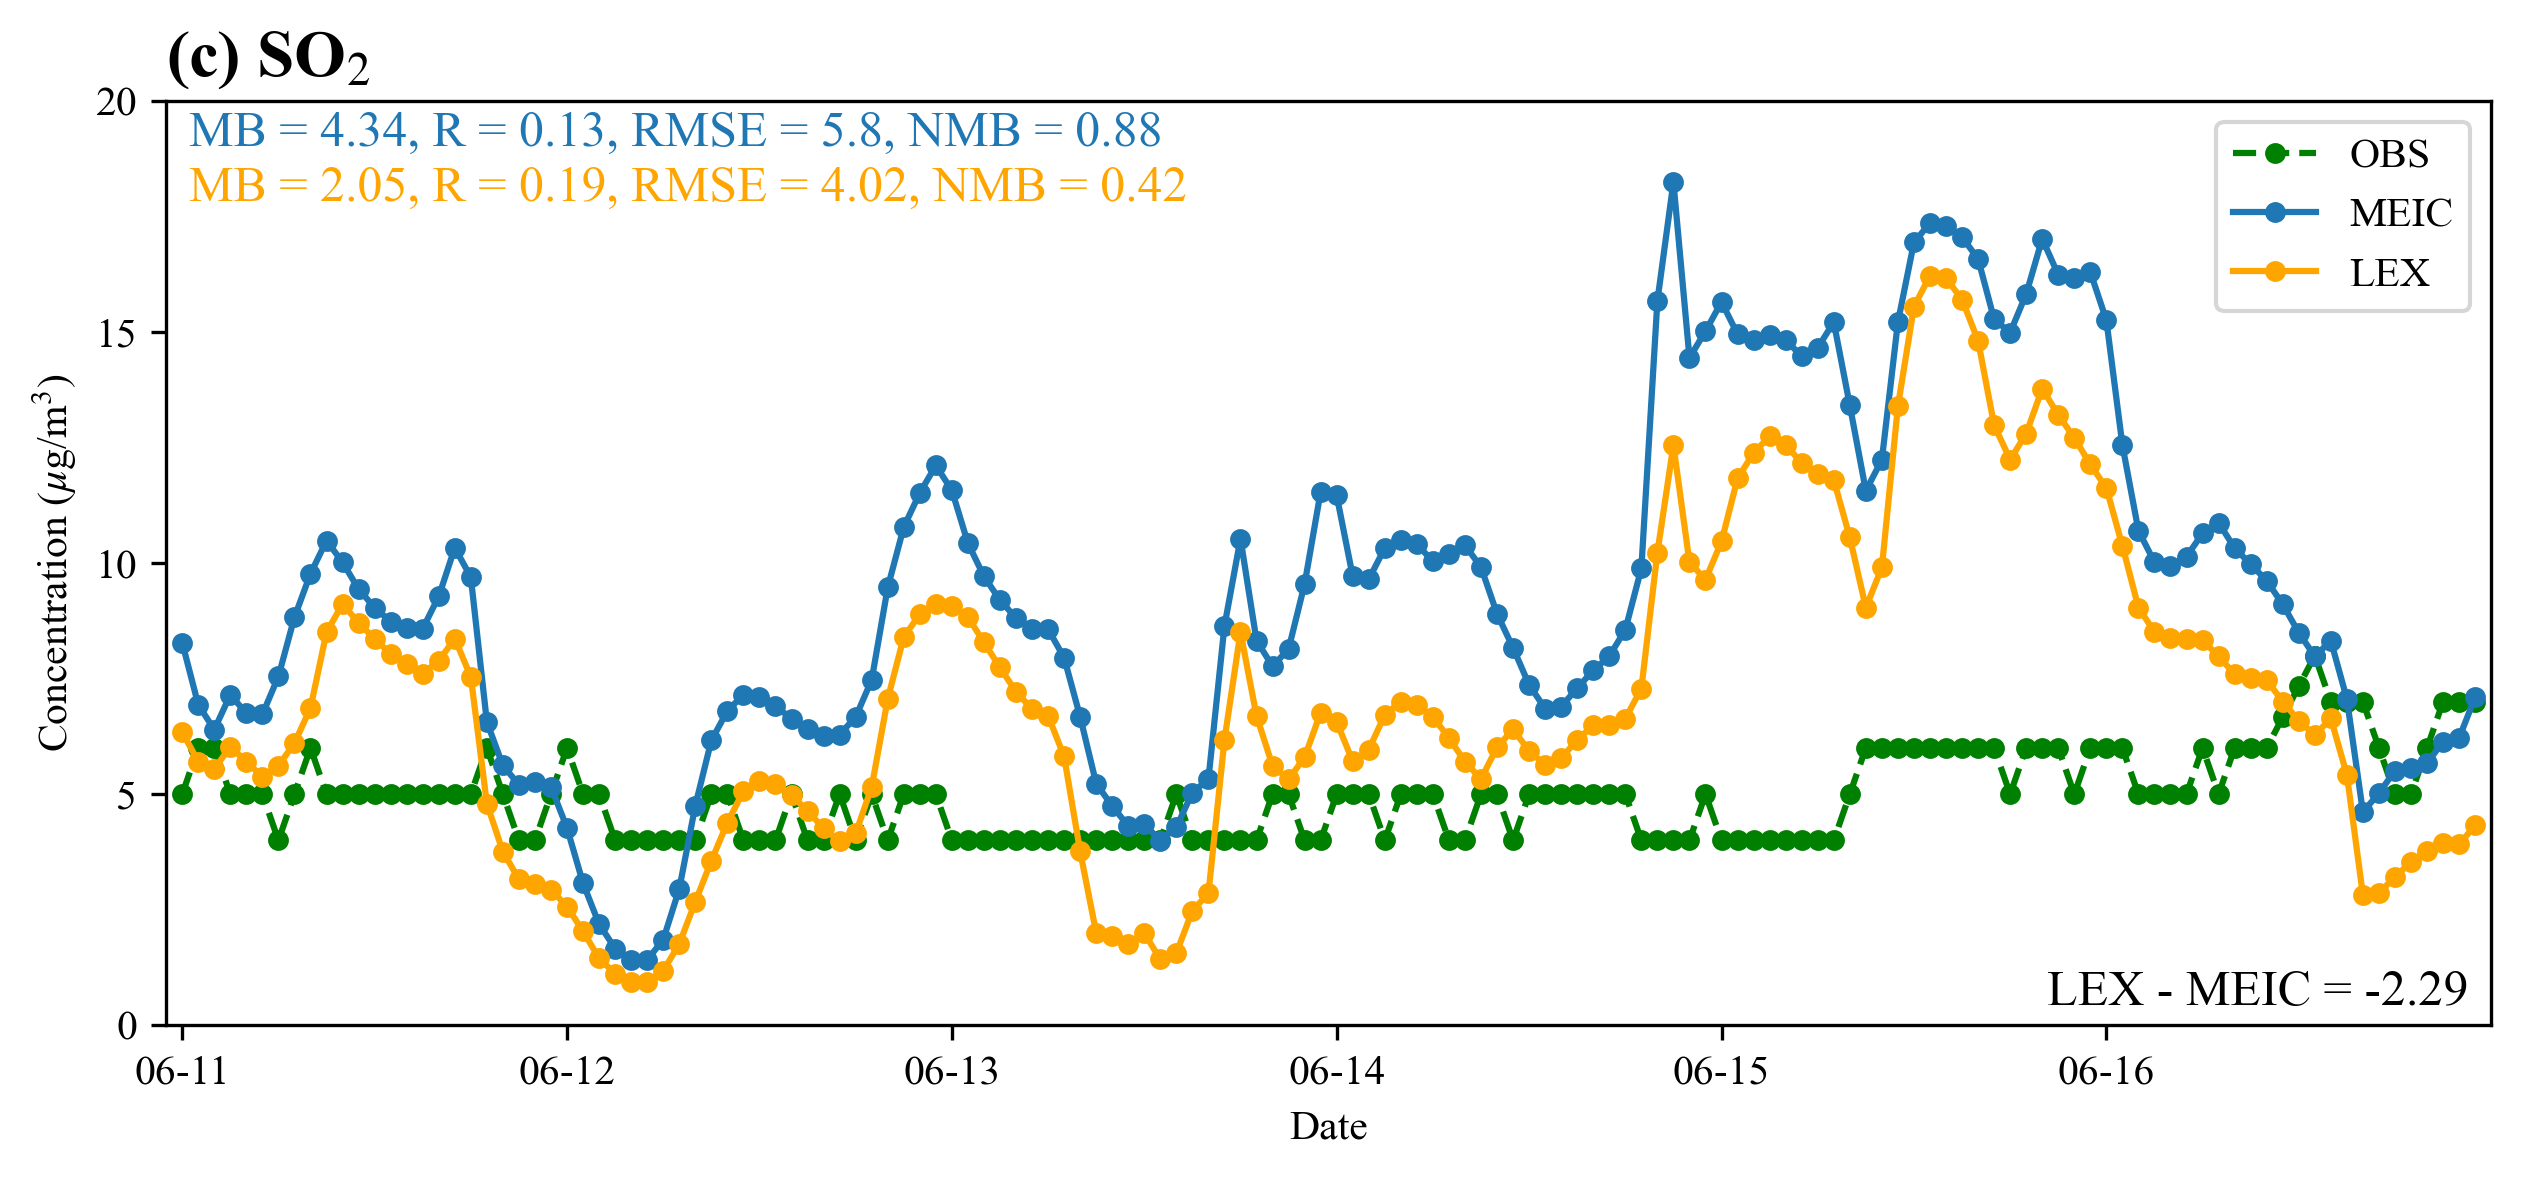

In [24]:
var='SO2'
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,xsobs[var],**obs_args)
ax.plot(ts,df_meic[var],**meic_args)
ax.plot(ts,df_lex[var],**lex_args)
ax.legend(loc=1)

# calculate parameters
MB_meic = np.nanmean(df_meic[var]-xsobs[var])
R_meic,_ = pearsonr(xsobs[var],df_meic[var])
RMSE_meic = np.sqrt(np.nanmean((df_meic[var]-xsobs[var])**2))
NMB_meic = MB_meic / np.mean(xsobs[var])

MB_lex = np.nanmean(df_lex[var]-xsobs[var])
R_lex,_ = pearsonr(xsobs[var],df_lex[var])
RMSE_lex = np.sqrt(np.nanmean((df_lex[var]-xsobs[var])**2))
NMB_lex = MB_lex / np.mean(xsobs[var])

diff_mean = np.nanmean(df_lex[var]-df_meic[var])

# strings
str_mb_meic   = 'MB = '+str(np.round(MB_meic,2))+', '
str_r_meic    = 'R = '+str(np.round(R_meic,2))+', '
str_rmse_meic = 'RMSE = '+str(np.round(RMSE_meic,2))+', '
str_nmb_meic  = 'NMB = '+str(np.round(NMB_meic,2))
str_meic      = str_mb_meic+str_r_meic+str_rmse_meic+str_nmb_meic

ax.text(x=0.01,y=0.99,s=str_meic,color='tab:blue',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mb_lex   = 'MB = '+str(np.round(MB_lex,2))+', '
str_r_lex    = 'R = '+str(np.round(R_lex,2))+', '
str_rmse_lex = 'RMSE = '+str(np.round(RMSE_lex,2))+', '
str_nmb_lex  = 'NMB = '+str(np.round(NMB_lex,2))
str_lex      = str_mb_lex+str_r_lex+str_rmse_lex+str_nmb_lex

ax.text(x=0.01,y=0.93,s=str_lex,color='orange',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mean = 'LEX - MEIC = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,21,5))
ax.set_ylim(0,20)
ax.set_xlim(-1,hours)
ax.set_title('(c) SO$_2$',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

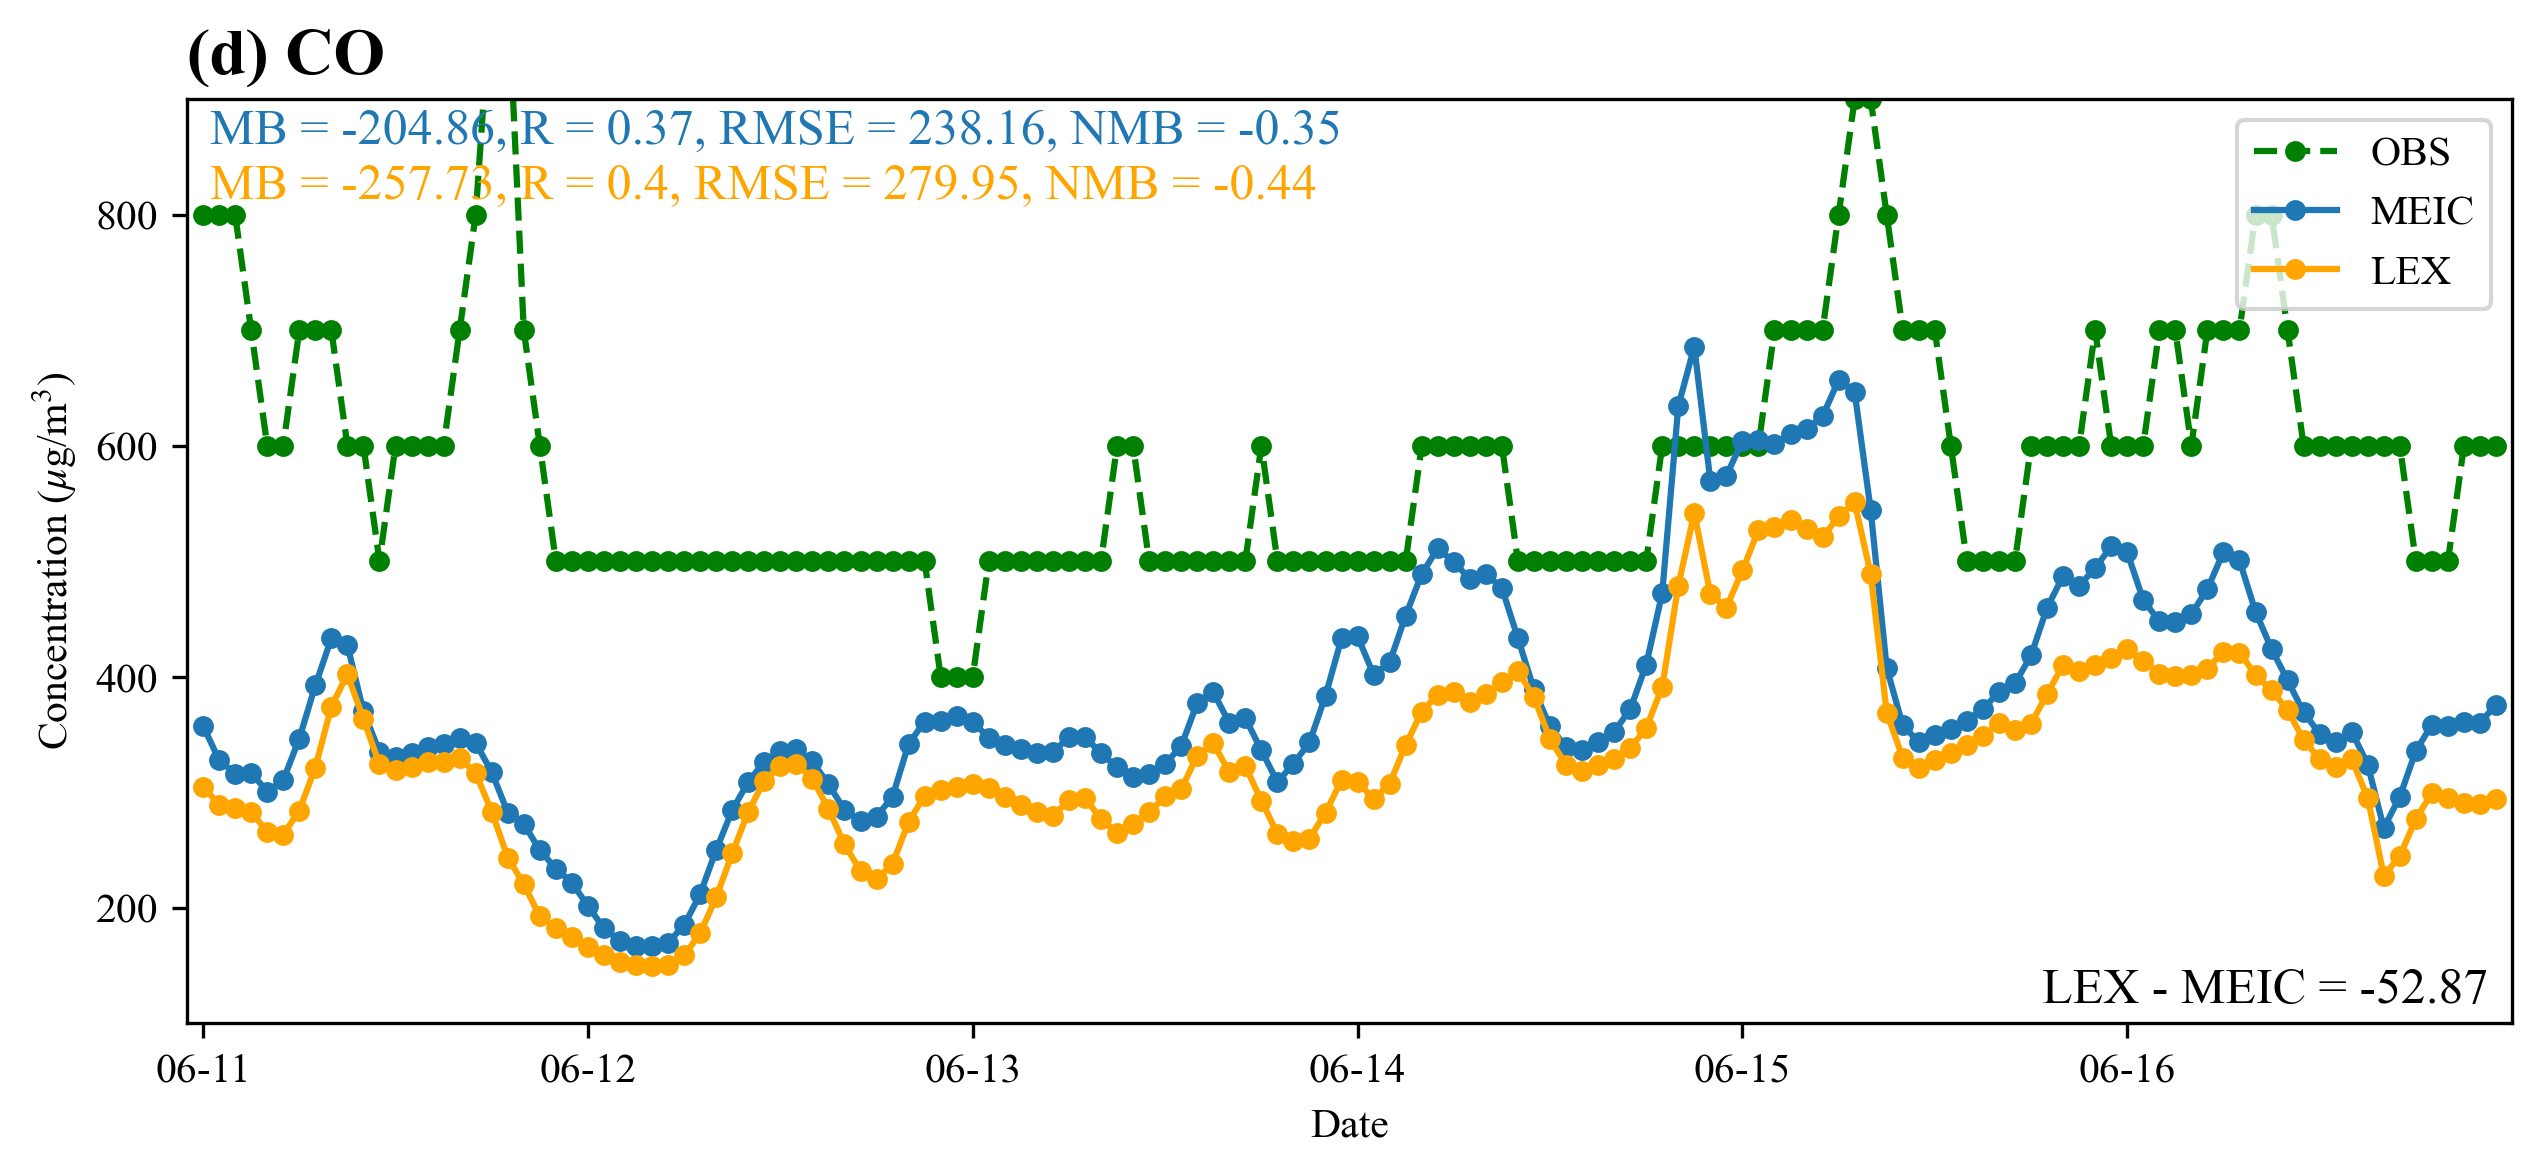

In [32]:
var = 'CO'
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

obsdata = xsobs['CO']*1000
ax.plot(ts,obsdata,**obs_args)
ax.plot(ts,df_meic[var],**meic_args)
ax.plot(ts,df_lex[var],**lex_args)
ax.legend(loc=1)

# calculate parameters
MB_meic = np.nanmean(df_meic[var]-obsdata)
R_meic,_ = pearsonr(obsdata,df_meic[var])
RMSE_meic = np.sqrt(np.nanmean((df_meic[var]-obsdata)**2))
NMB_meic = MB_meic / np.mean(obsdata)

MB_lex = np.nanmean(df_lex[var]-obsdata)
R_lex,_ = pearsonr(obsdata,df_lex[var])
RMSE_lex = np.sqrt(np.nanmean((df_lex[var]-obsdata)**2))
NMB_lex = MB_lex / np.mean(obsdata)

diff_mean = np.nanmean(df_lex[var]-df_meic[var])

# strings
str_mb_meic   = 'MB = '+str(np.round(MB_meic,2))+', '
str_r_meic    = 'R = '+str(np.round(R_meic,2))+', '
str_rmse_meic = 'RMSE = '+str(np.round(RMSE_meic,2))+', '
str_nmb_meic  = 'NMB = '+str(np.round(NMB_meic,2))
str_meic      = str_mb_meic+str_r_meic+str_rmse_meic+str_nmb_meic

ax.text(x=0.01,y=0.99,s=str_meic,color='tab:blue',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mb_lex   = 'MB = '+str(np.round(MB_lex,2))+', '
str_r_lex    = 'R = '+str(np.round(R_lex,2))+', '
str_rmse_lex = 'RMSE = '+str(np.round(RMSE_lex,2))+', '
str_nmb_lex  = 'NMB = '+str(np.round(NMB_lex,2))
str_lex      = str_mb_lex+str_r_lex+str_rmse_lex+str_nmb_lex

ax.text(x=0.01,y=0.93,s=str_lex,color='orange',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mean = 'LEX - MEIC = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,901,200))
ax.set_ylim(100,900)
ax.set_xlim(-1,hours)
ax.set_title('(d) CO',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

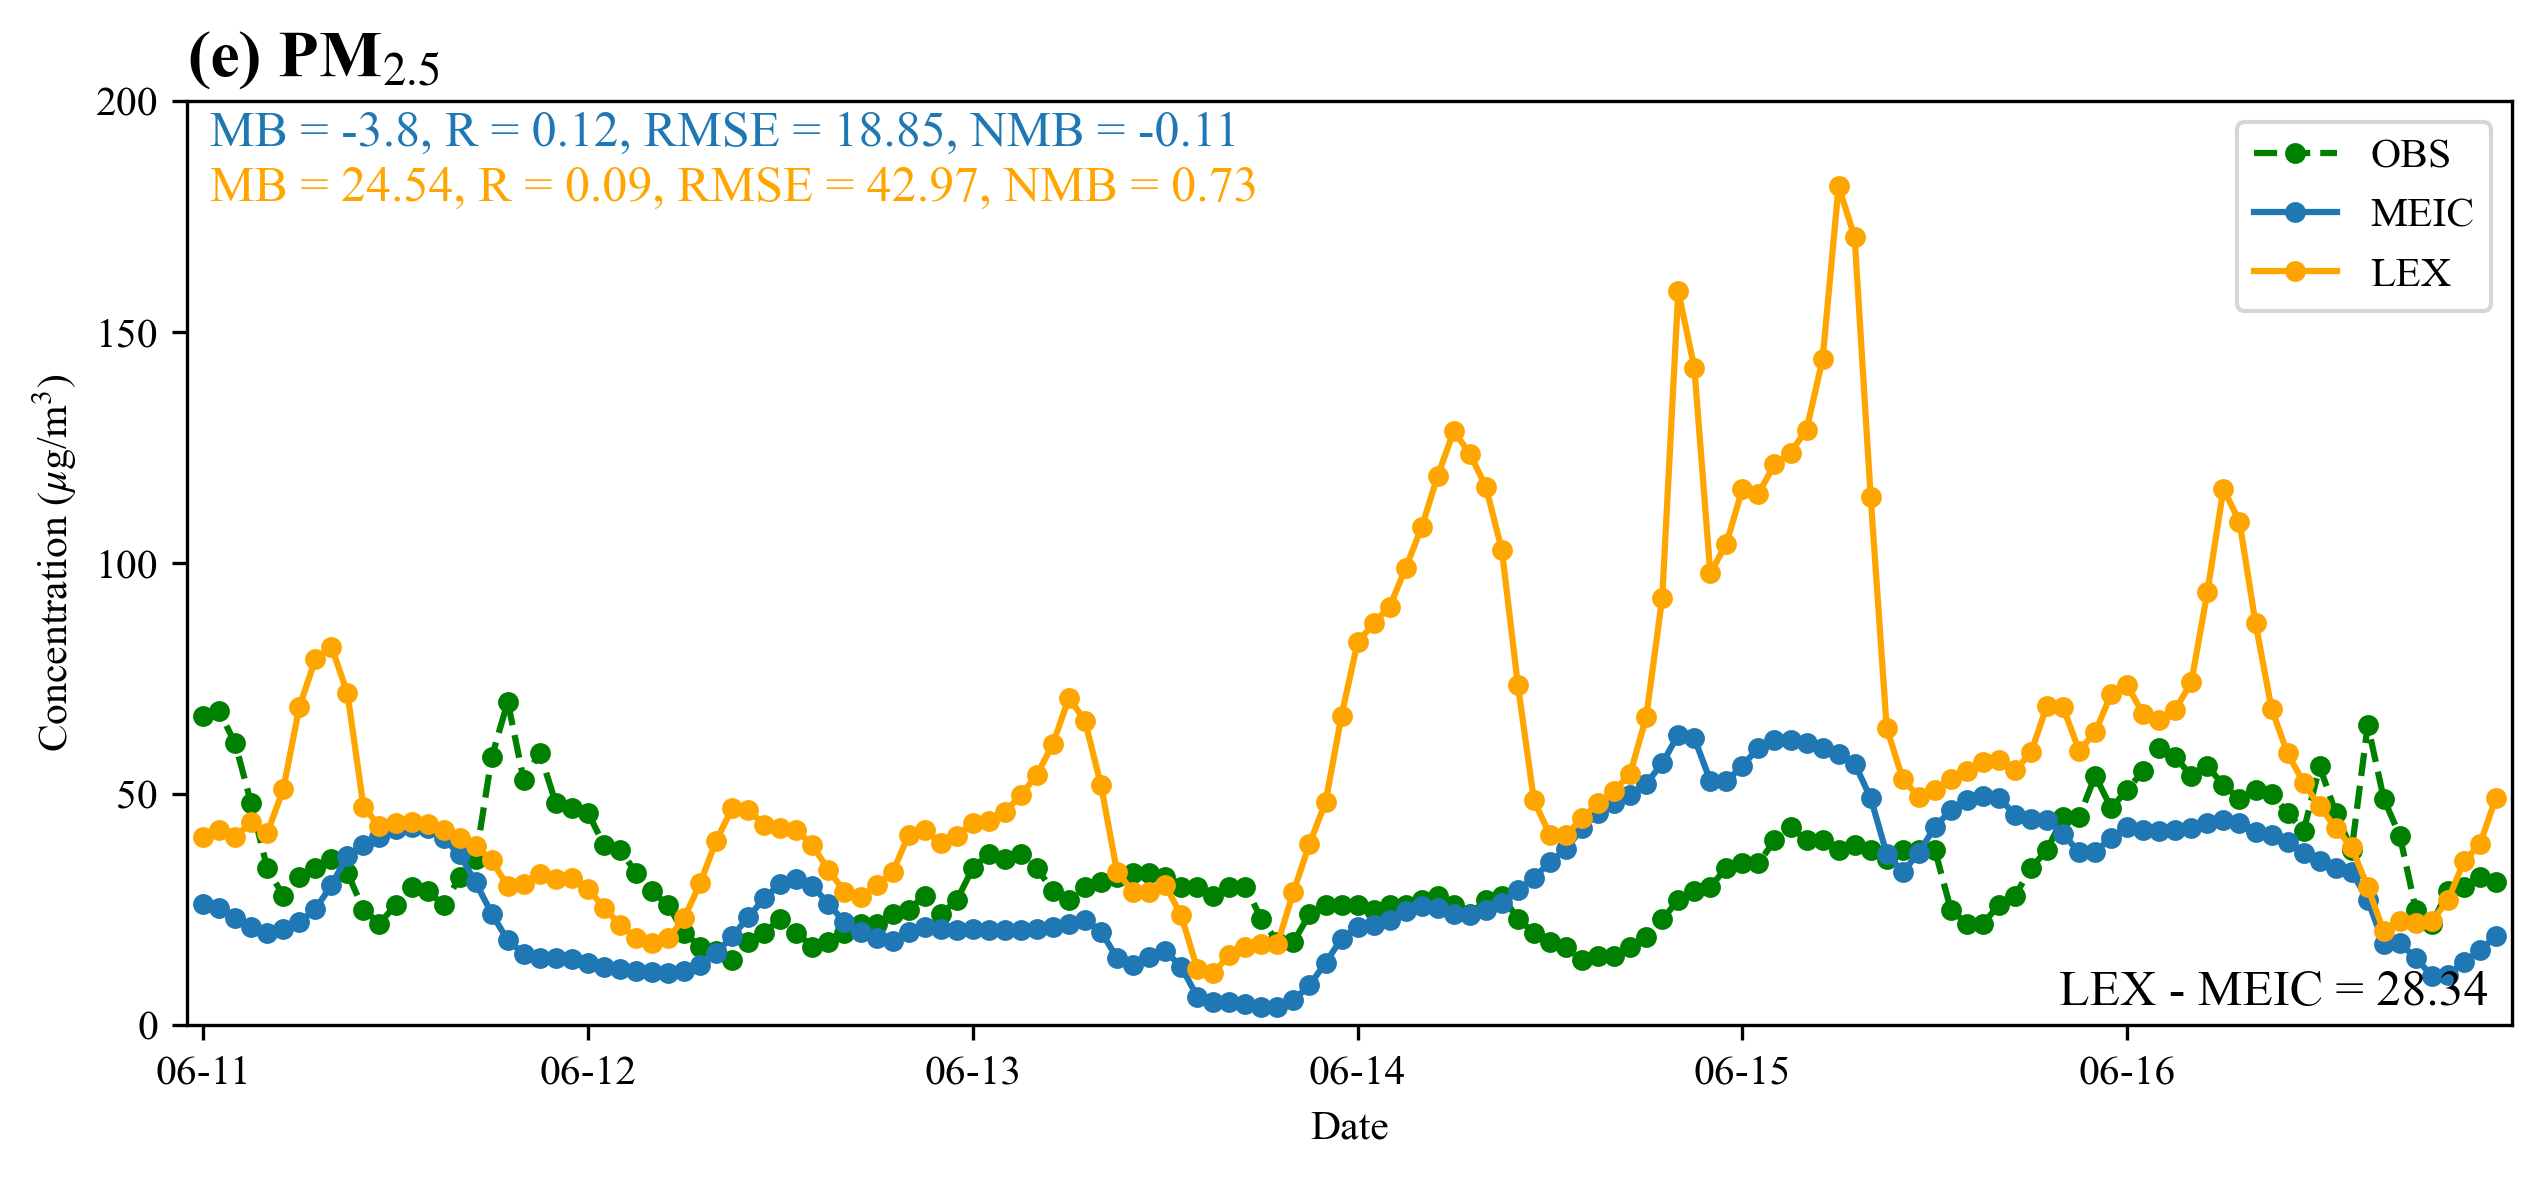

In [34]:
var = 'PM25'
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,xsobs['PM2.5'],**obs_args)
ax.plot(ts,df_meic['PM25'],**meic_args)
ax.plot(ts,df_lex['PM25'],**lex_args)
ax.legend(loc=1)

# calculate parameters
MB_meic = np.nanmean(df_meic[var]-xsobs['PM2.5'])
R_meic,_ = pearsonr(xsobs['PM2.5'],df_meic[var])
RMSE_meic = np.sqrt(np.nanmean((df_meic[var]-xsobs['PM2.5'])**2))
NMB_meic = MB_meic / np.mean(xsobs['PM2.5'])

MB_lex = np.nanmean(df_lex[var]-xsobs['PM2.5'])
R_lex,_ = pearsonr(xsobs['PM2.5'],df_lex[var])
RMSE_lex = np.sqrt(np.nanmean((df_lex[var]-xsobs['PM2.5'])**2))
NMB_lex = MB_lex / np.mean(xsobs['PM2.5'])

diff_mean = np.nanmean(df_lex[var]-df_meic[var])

# strings
str_mb_meic   = 'MB = '+str(np.round(MB_meic,2))+', '
str_r_meic    = 'R = '+str(np.round(R_meic,2))+', '
str_rmse_meic = 'RMSE = '+str(np.round(RMSE_meic,2))+', '
str_nmb_meic  = 'NMB = '+str(np.round(NMB_meic,2))
str_meic      = str_mb_meic+str_r_meic+str_rmse_meic+str_nmb_meic

ax.text(x=0.01,y=0.99,s=str_meic,color='tab:blue',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mb_lex   = 'MB = '+str(np.round(MB_lex,2))+', '
str_r_lex    = 'R = '+str(np.round(R_lex,2))+', '
str_rmse_lex = 'RMSE = '+str(np.round(RMSE_lex,2))+', '
str_nmb_lex  = 'NMB = '+str(np.round(NMB_lex,2))
str_lex      = str_mb_lex+str_r_lex+str_rmse_lex+str_nmb_lex

ax.text(x=0.01,y=0.93,s=str_lex,color='orange',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mean = 'LEX - MEIC = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,201,50))
ax.set_ylim(0,200)
ax.set_xlim(-1,hours)
ax.set_title('(e) PM$_{2.5}$',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

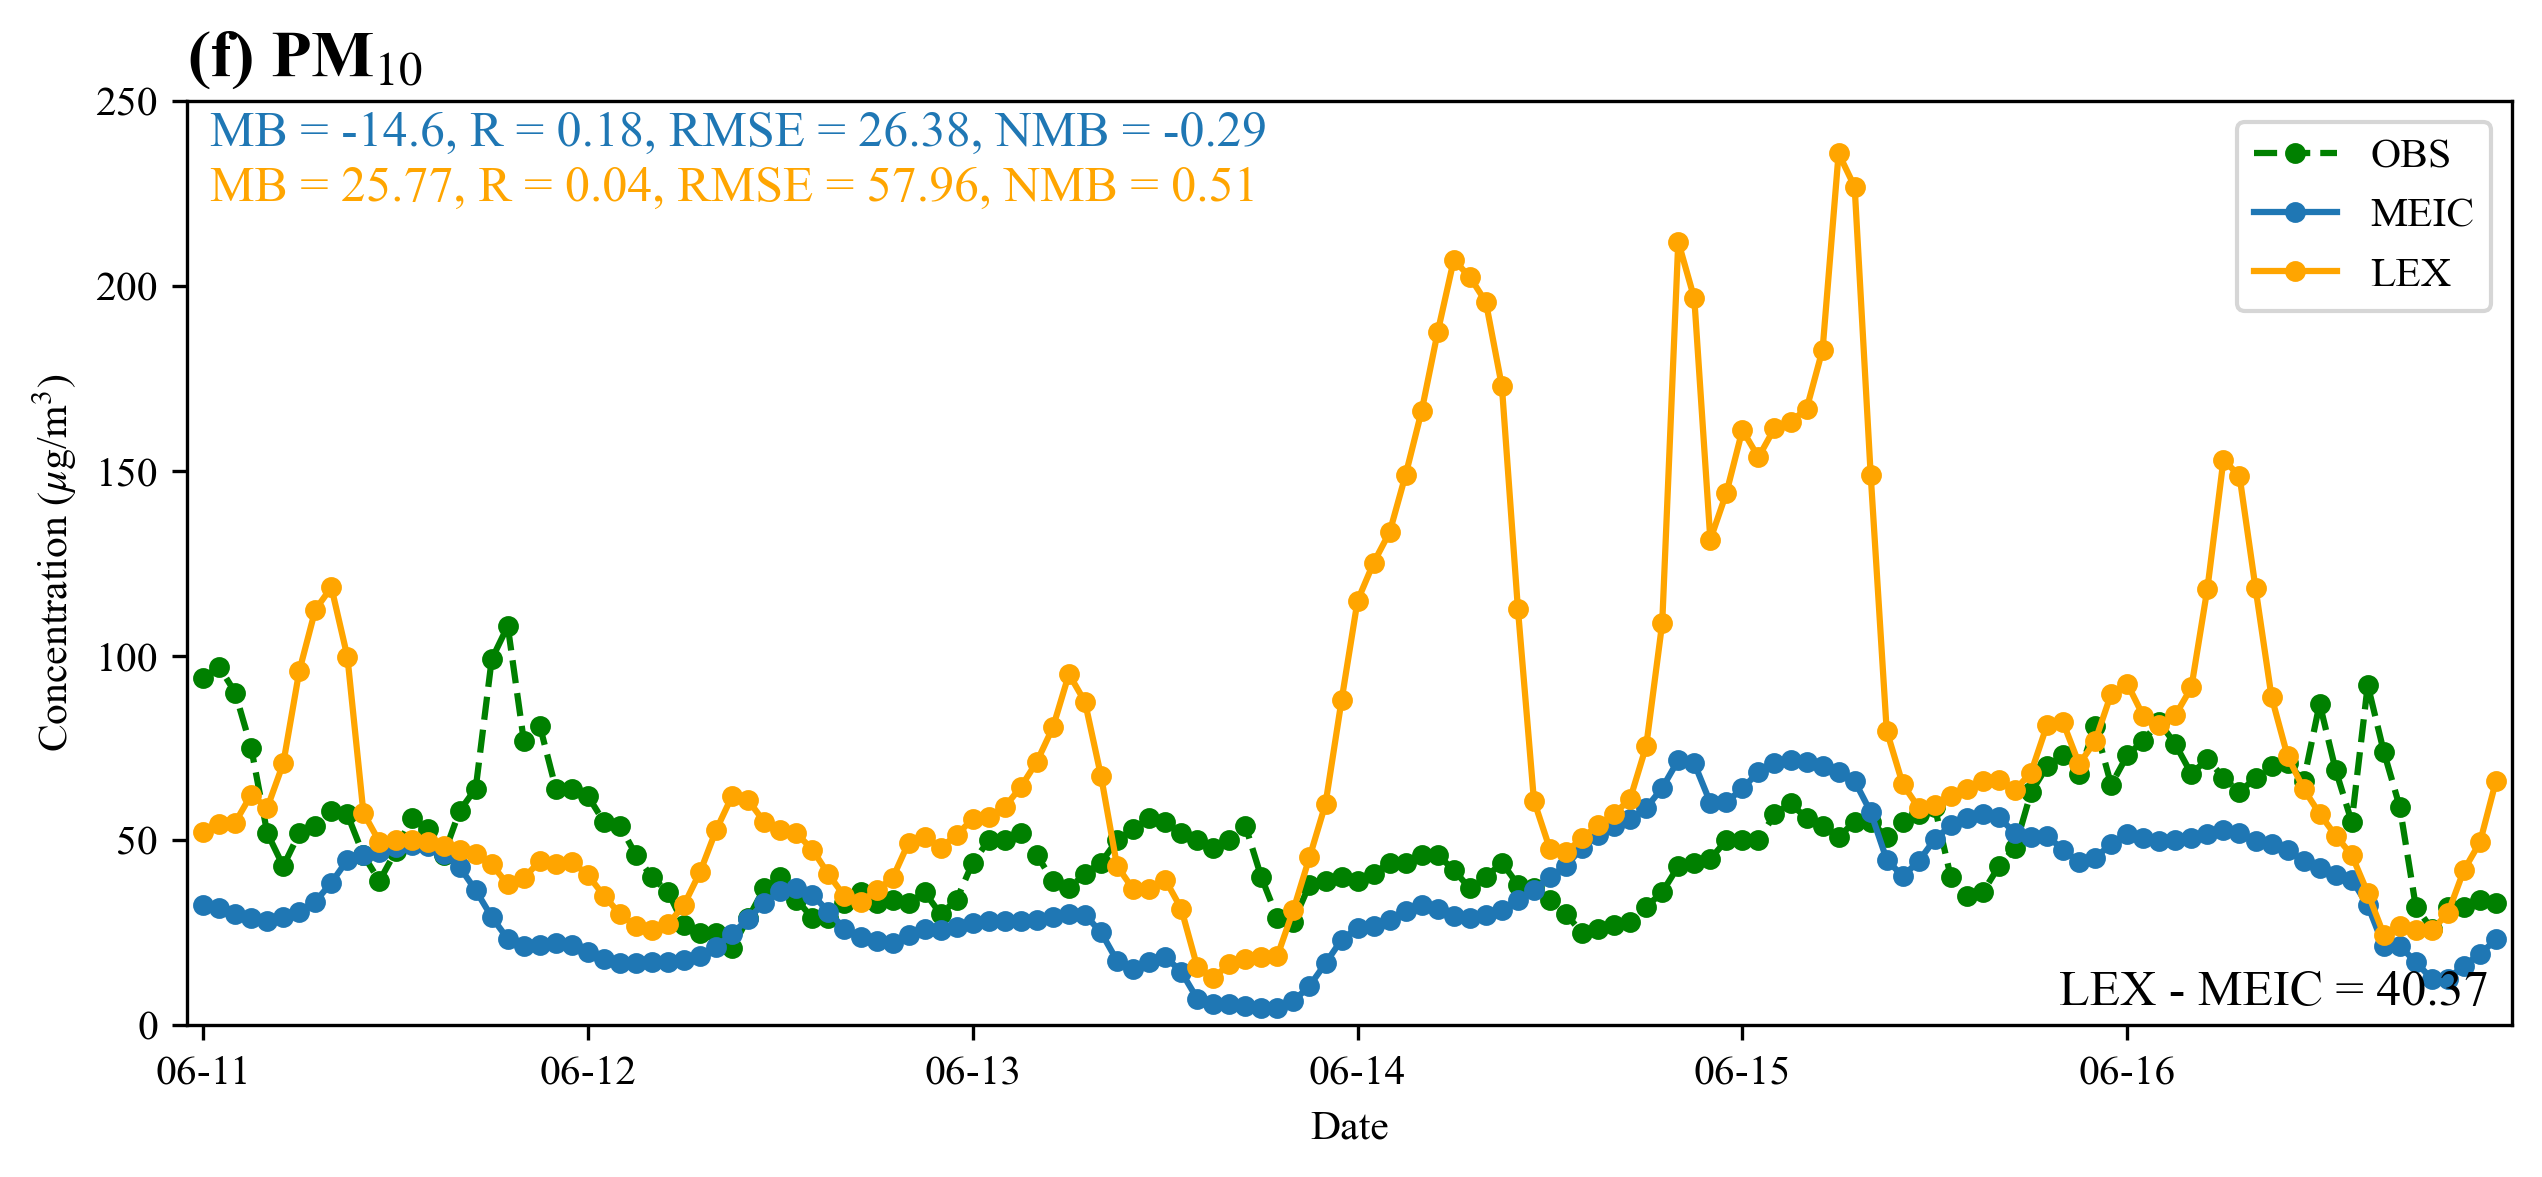

In [35]:
var = 'PM10'
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,xsobs[var],**obs_args)
ax.plot(ts,df_meic[var],**meic_args)
ax.plot(ts,df_lex[var],**lex_args)
ax.legend(loc=1)

# calculate parameters
MB_meic = np.nanmean(df_meic[var]-xsobs[var])
R_meic,_ = pearsonr(xsobs[var],df_meic[var])
RMSE_meic = np.sqrt(np.nanmean((df_meic[var]-xsobs[var])**2))
NMB_meic = MB_meic / np.mean(xsobs[var])

MB_lex = np.nanmean(df_lex[var]-xsobs[var])
R_lex,_ = pearsonr(xsobs[var],df_lex[var])
RMSE_lex = np.sqrt(np.nanmean((df_lex[var]-xsobs[var])**2))
NMB_lex = MB_lex / np.mean(xsobs[var])

diff_mean = np.nanmean(df_lex[var]-df_meic[var])

# strings
str_mb_meic   = 'MB = '+str(np.round(MB_meic,2))+', '
str_r_meic    = 'R = '+str(np.round(R_meic,2))+', '
str_rmse_meic = 'RMSE = '+str(np.round(RMSE_meic,2))+', '
str_nmb_meic  = 'NMB = '+str(np.round(NMB_meic,2))
str_meic      = str_mb_meic+str_r_meic+str_rmse_meic+str_nmb_meic

ax.text(x=0.01,y=0.99,s=str_meic,color='tab:blue',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mb_lex   = 'MB = '+str(np.round(MB_lex,2))+', '
str_r_lex    = 'R = '+str(np.round(R_lex,2))+', '
str_rmse_lex = 'RMSE = '+str(np.round(RMSE_lex,2))+', '
str_nmb_lex  = 'NMB = '+str(np.round(NMB_lex,2))
str_lex      = str_mb_lex+str_r_lex+str_rmse_lex+str_nmb_lex

ax.text(x=0.01,y=0.93,s=str_lex,color='orange',
        fontsize=12,ha='left',va='top',transform=ax.transAxes)

str_mean = 'LEX - MEIC = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,251,50))
ax.set_ylim(0,250)
ax.set_xlim(-1,hours)
ax.set_title('(f) PM$_{10}$',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()

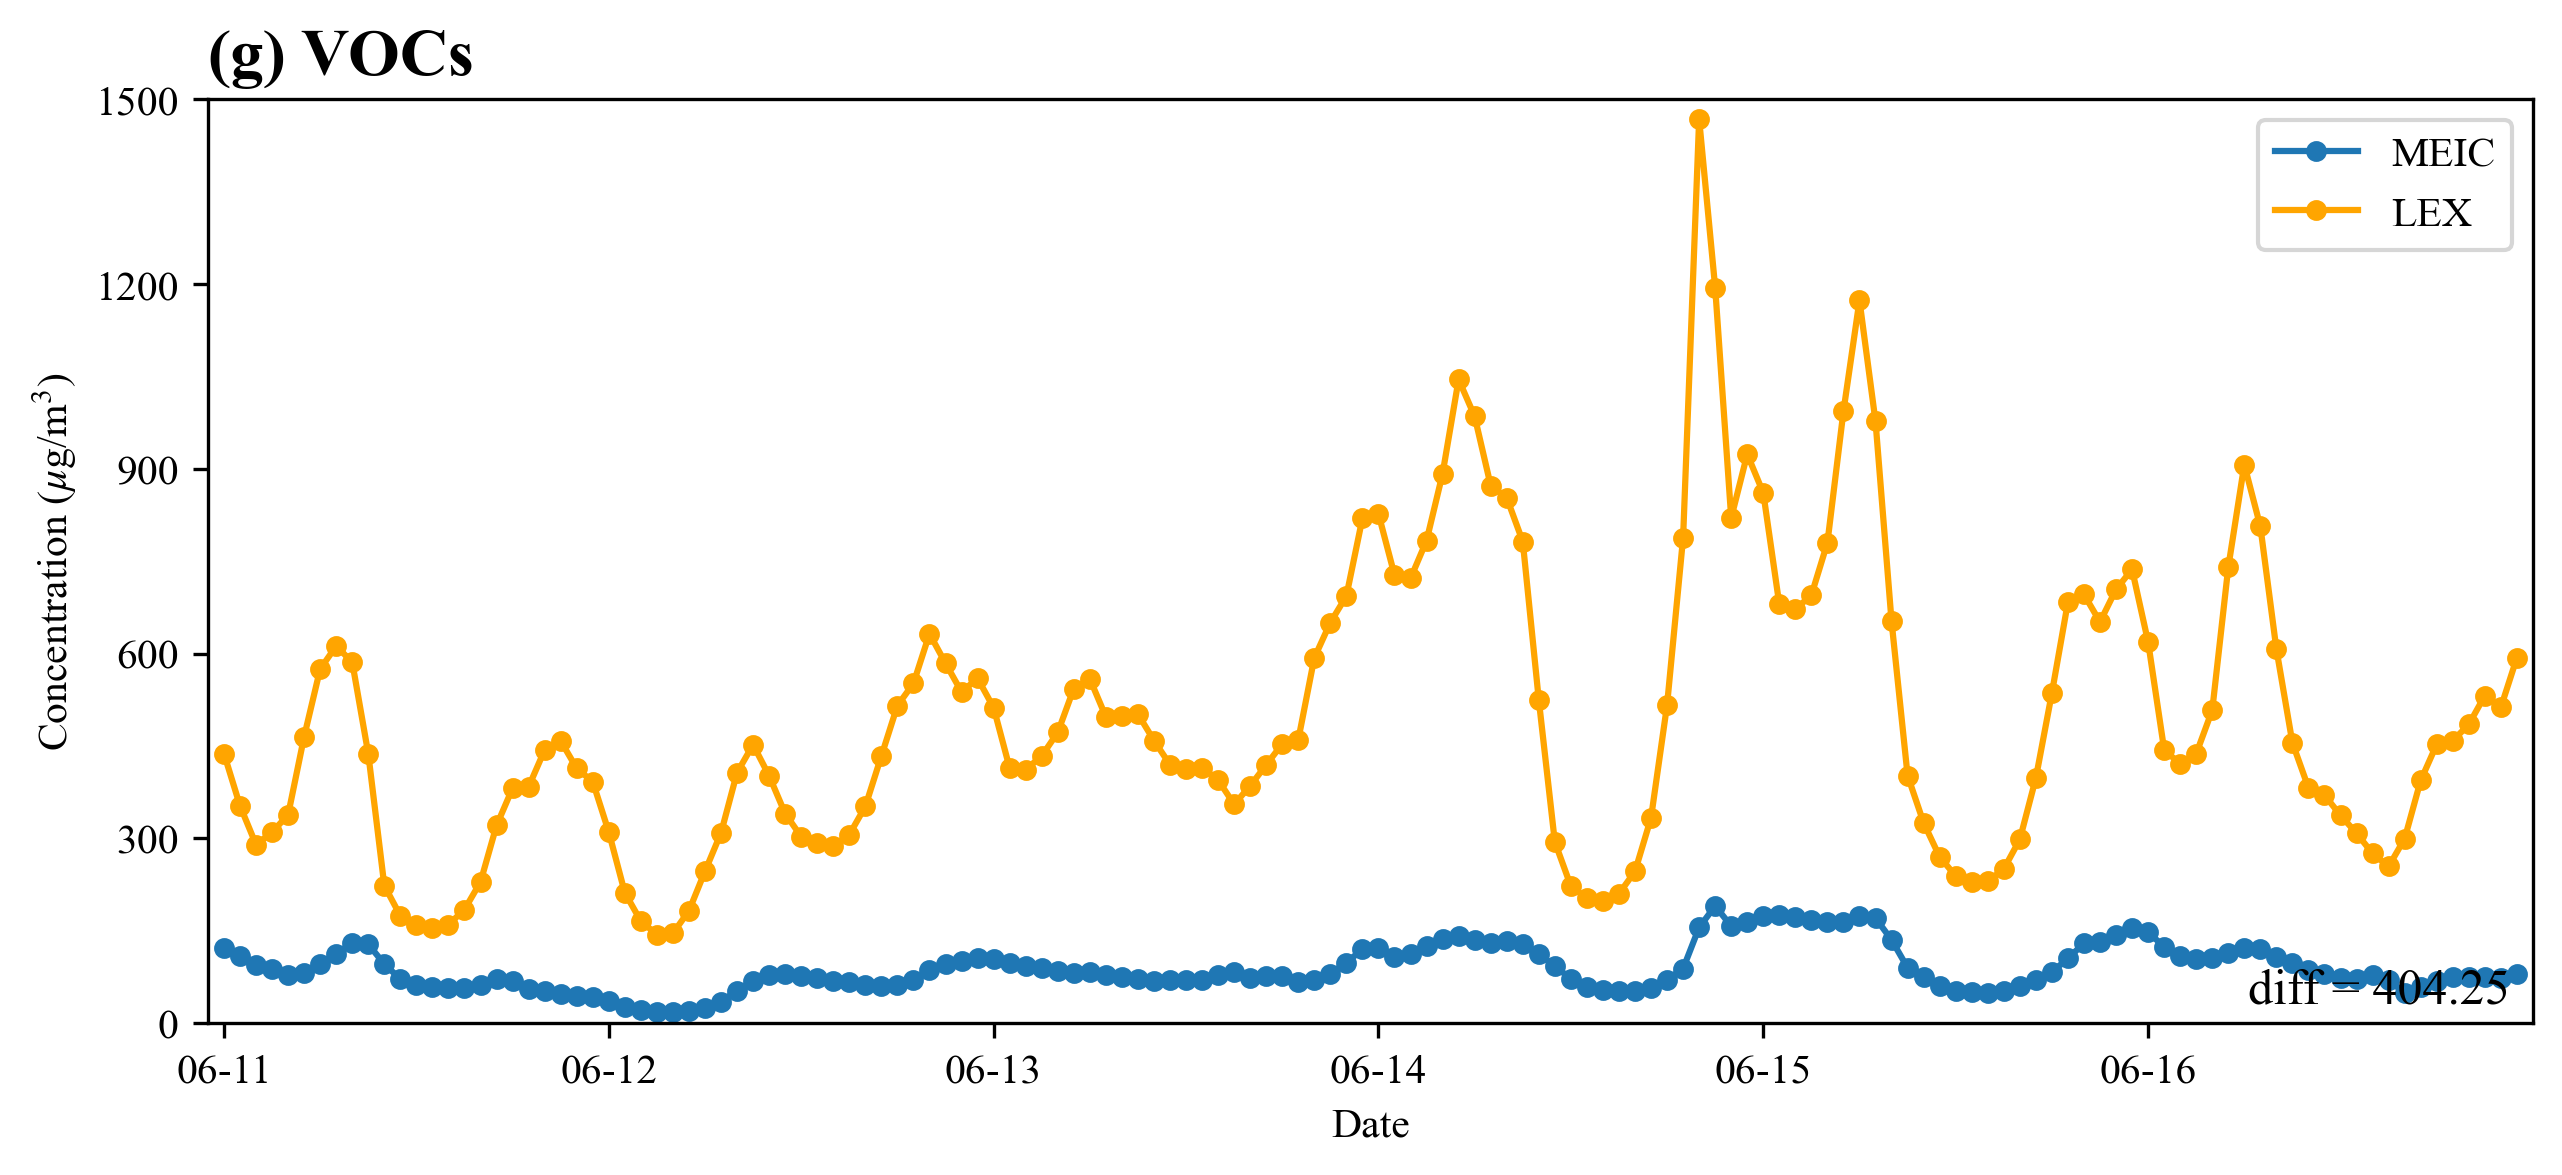

In [70]:
hours = 144
days = 6

ts = np.arange(0,hours)

meic_args = dict(color='tab:blue',label='MEIC',marker='.',markersize=8)
lex_args  = dict(color='orange',label='LEX',marker='.',markersize=8)
obs_args  = dict(color='green',label='OBS',marker='.',markersize=8,linestyle='--')

fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

ax.plot(ts,df_meic['VOC'],**meic_args)
ax.plot(ts,df_lex['VOC'],**lex_args)
ax.legend(loc=1)

diff_mean = np.mean(df_lex['VOC']-df_meic['VOC'])
str_mean = 'diff = '+str(np.round(diff_mean,2))
ax.text(x=0.99,y=0.01,s=str_mean,
        fontsize=12,ha='right',va='bottom',transform=ax.transAxes)

ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$g/m$^3$)')
ax.set_xticks(np.arange(0,hours,24))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'))
ax.set_yticks(np.arange(0,1501,300))
ax.set_ylim(0,1500)
ax.set_xlim(-1,hours)
ax.set_title('(g) VOCs',fontdict={'fontsize':16,'weight':'bold'},loc='left')

plt.show()